In [1]:
!pip install imageio
!pip install scikit-image
import imageio as io
import numpy as np
import numpy.ma as ma
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import logging
from skimage.filters import median
from skimage.morphology import cube
logging.basicConfig(level=logging.INFO)
from cil.io import TIFFStackReader
from cil.framework import AcquisitionGeometry, AcquisitionData
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.recon import FDK
from cil.utilities.display import show2D, show_geometry
from cil.utilities.jupyter import islicer, link_islicer
# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator,\
                                       GradientOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction
from cil.processors import CentreOfRotationCorrector, Slicer, TransmissionAbsorptionConverter
from cil.plugins.astra import ProjectionOperator
from cil.plugins.ccpi_regularisation.functions import FGP_TV

In [2]:
#load projection data from tiffs in folder
path = 'N:/ILL_Data_230808/rawdata/AC/25_ILL_AC_15mm_15s/Proj'
proj_arr = []
for i in os.listdir(path):
    proj = io.imread(path+'/'+i)
    proj_arr.append(proj)
proj_arr = np.array(proj_arr)[:,850:1300,400:1700]

C:\Users\ucecmjo\AppData\Local\Temp\8\ipykernel_32784\670190188.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  proj = io.imread(path+'/'+i)


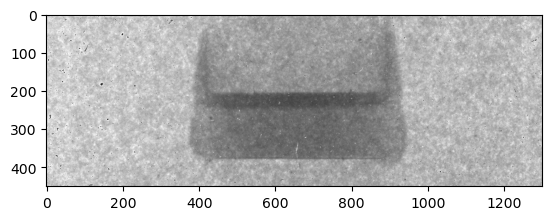

In [3]:
plt.imshow((proj_arr[250]*30).astype(np.uint16), cmap = 'gray')
plt.show()

In [4]:
# load flat and dark
# flat and dark averaging (mean)
# multiple flats and darks are averaged so that variation is taken into account when correction is applied
path_f = 'N:/ILL_Data_230808/rawdata/AC/24_flats_15mm_15s'
flat_arr = []
for i in os.listdir(path_f):
    f = io.imread(path_f+'/'+i)
    flat_arr.append(f)
flat_arr = np.array(flat_arr)[:,850:1300,400:1700]
flat_arr = np.mean(flat_arr, 0)
io.imwrite('N:/ILL_Data_230808/rawdata/AC/Processed/flat.tiff', flat_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

path_d = 'N:/ILL_Data_230808/rawdata/AC/26_darks_15mm_15s'
dark_arr = []
for l in os.listdir(path_d):
    d = io.imread(path_d+'/'+l)
    dark_arr.append(d)
dark_arr = np.array(dark_arr)[:,850:1300,400:1700]
dark_arr = np.mean(dark_arr, 0)
io.imwrite('N:/ILL_Data_230808/rawdata/AC/Processed/dark.tiff', dark_arr.astype(np.uint16), format='tiff') # note only converting to 16 bit for save

C:\Users\ucecmjo\AppData\Local\Temp\8\ipykernel_32784\1503575600.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f = io.imread(path_f+'/'+i)
C:\Users\ucecmjo\AppData\Local\Temp\8\ipykernel_32784\1503575600.py:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  d = io.imread(path_d+'/'+l)


In [5]:
# apply normalisation and save to disk
# here dark flat correction is applied as... normed = (projection - dark_field) / (flat_field - dark_field) 
proj_normed = []
for i in tqdm(range(proj_arr.shape[0])):
    im = (proj_arr[i] - dark_arr)/(flat_arr - dark_arr)
    im = np.where(im > 0, im, 0) #new to remove negatives
    proj_normed.append(im)
proj_normed = np.array(proj_normed)
io.volwrite('N:/ILL_Data_230808/rawdata/AC/Processed/normed_proj.tiff', proj_normed, format='tiff', bigtiff=True)

100%|██████████████████████████████████████████████████████████████████████████████| 1216/1216 [00:21<00:00, 57.69it/s]


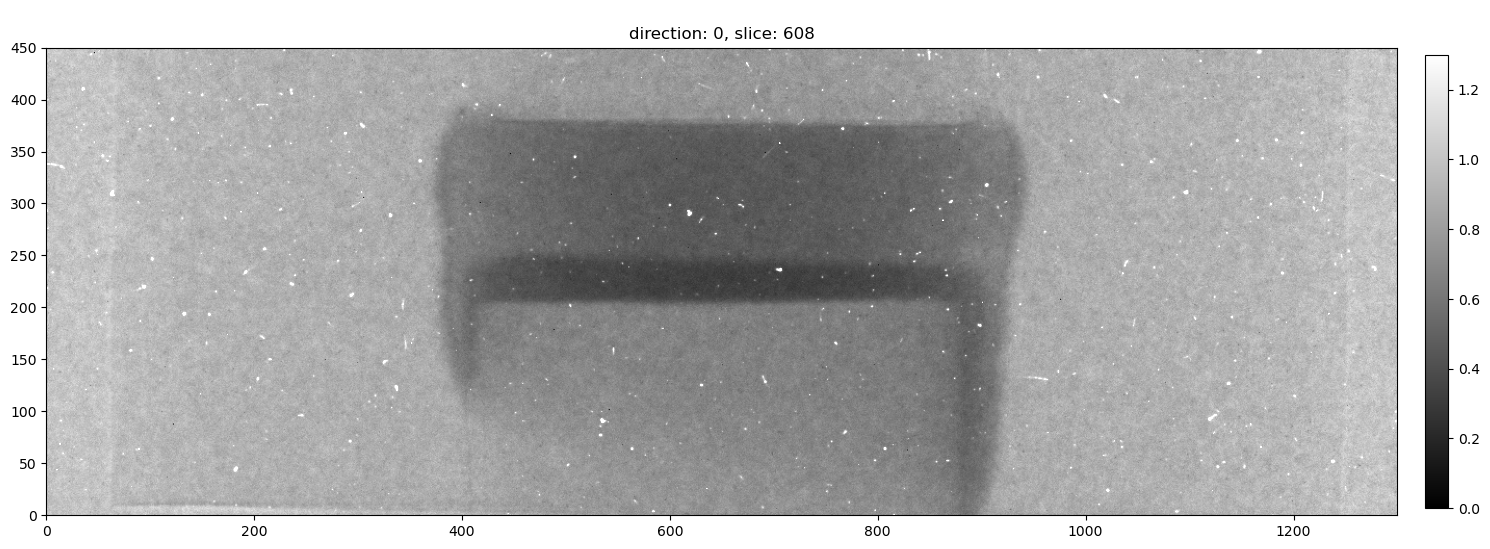

In [6]:
show2D(proj_normed,fix_range=(0,1.3))

In [7]:
# filter the salt and pepper from the undersampled & high scattered NT image (neutrons suck x-rays ftw)
# normalise result between 0 - 1 range

#proj_filt = median(proj_normed, cube(7))
#proj_filt = np.nan_to_num(proj_filt)
#proj_filt = proj_filt/np.amax(proj_filt)
#io.volwrite('median_proj.tiff', proj_filt, format='tiff', bigtiff=True)

proj_filt = io.volread('N:/ILL_Data_230808/Jupyter_notebooks/median_proj.tiff')

In [8]:
proj_adapt = np.where(proj_normed - proj_filt > 0.12, proj_filt, proj_normed) # removes white noise without smoothing the remaining data (maybe useful...?)
proj_adapt = np.where(proj_adapt < 0.01, proj_filt, proj_adapt) # removes dark noise without smoothing the remaining data (maybe useful...?)
proj_adapt = np.nan_to_num(proj_adapt)
proj_adapt = proj_adapt/np.amax(proj_adapt)
io.volwrite('adapt_proj.tiff', proj_adapt, format='tiff', bigtiff=True)

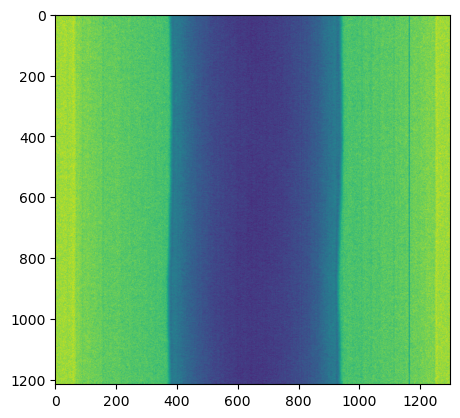

In [11]:
plt.imshow((proj_adapt[:,350,:]), cmap = 'viridis')
plt.show()

### CIL Reconstruction

### FBP without Projection Smoothing

In [12]:
proj_normed = io.volread('N:/ILL_Data_230808/Jupyter_notebooks/adapt_proj.tiff')

In [13]:
proj_normed = np.array(proj_normed, dtype = np.float32)

In [14]:
angle = 0 
angles = []
for j in range(1216):
    angles.append(angle)
    angle += (360/1215)
angles = np.array(angles) #no conversion to radians for CIL default

In [15]:
ag = AcquisitionGeometry.create_Parallel3D()  \
         .set_panel(num_pixels=[list(proj_normed.shape)[2],list(proj_normed.shape)[1]])        \
         .set_angles(angles=angles)

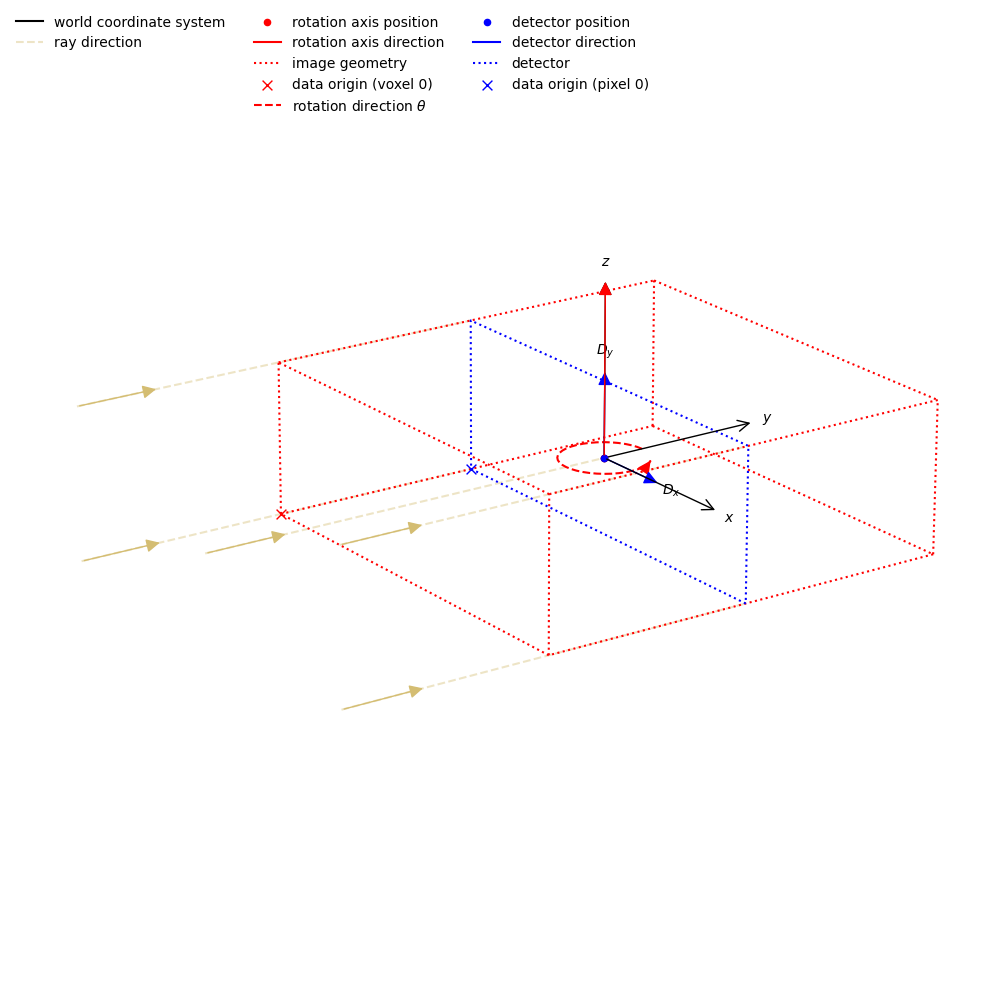

In [16]:
show_geometry(ag)

In [17]:
data = AcquisitionData(proj_normed, geometry = ag, deep_copy = True) 

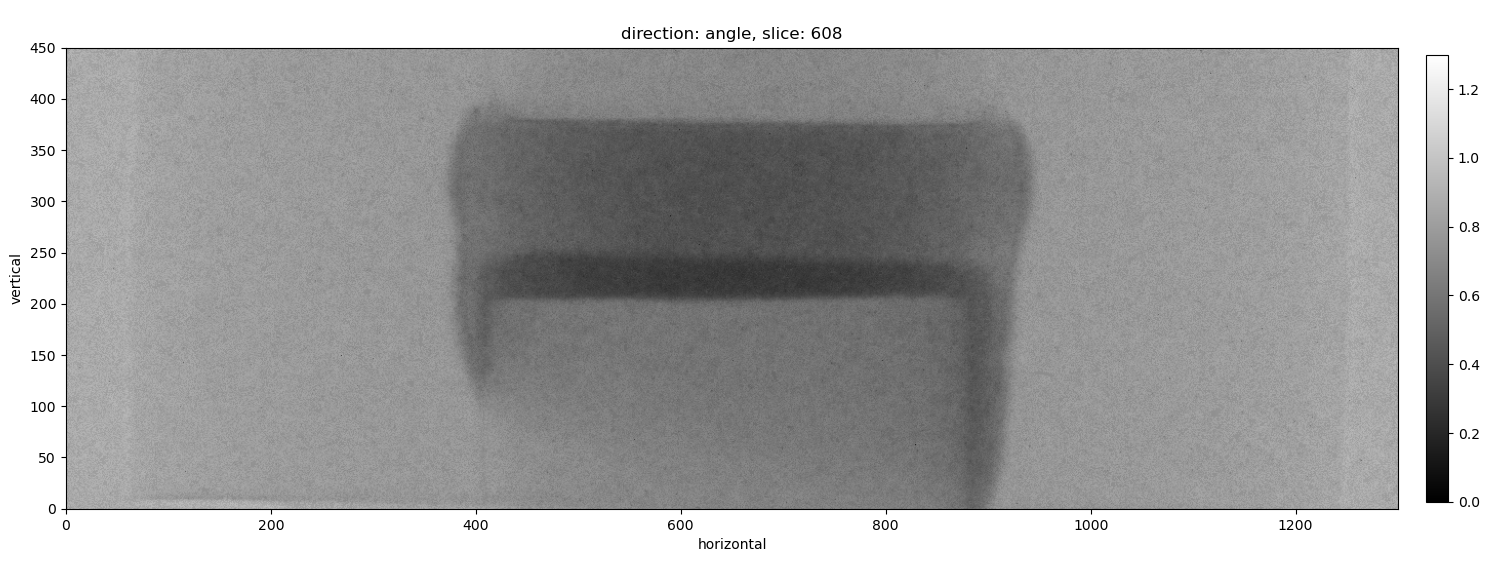

In [18]:
show2D(data,fix_range=(0,1.3))

In [19]:
data.reorder('astra')

In [20]:
ig = ag.get_ImageGeometry()

In [21]:
from cil.processors import TransmissionAbsorptionConverter
data2 = TransmissionAbsorptionConverter(white_level = 1,  min_intensity = 0.0)(data)

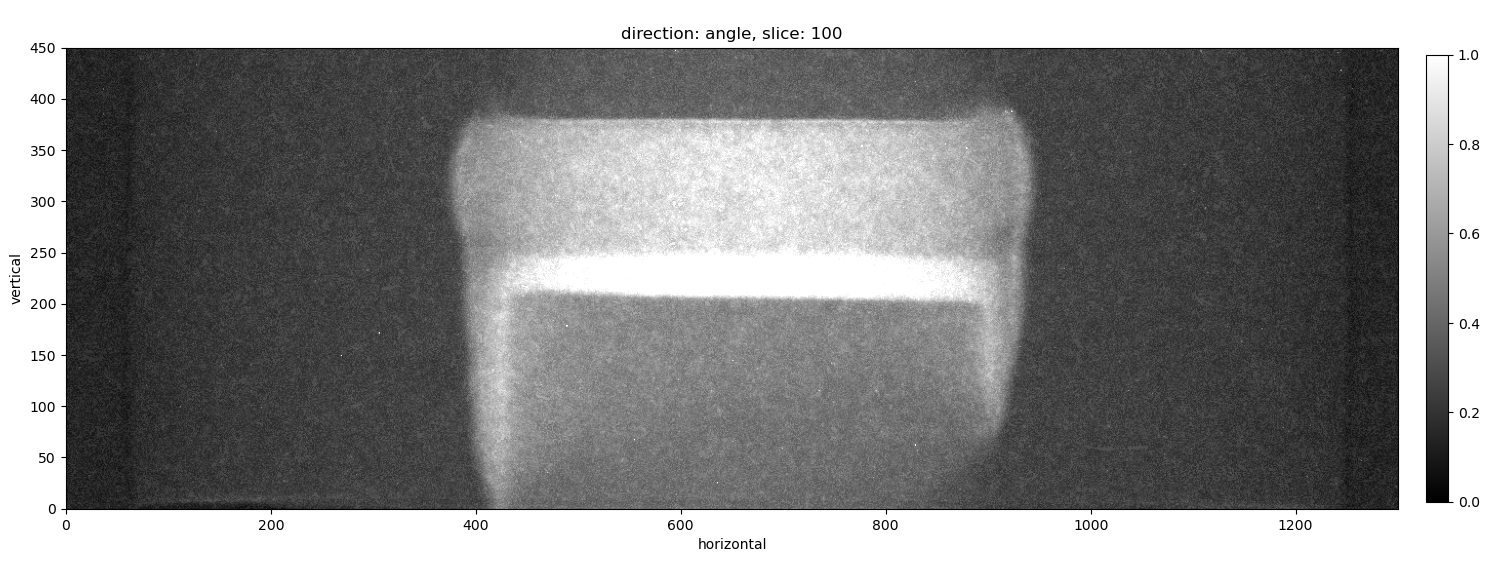

In [22]:
show2D(data2,fix_range=(0,1), slice_list = ('angle', 100))

In [23]:
data2.reorder('astra')

In [24]:
from cil.recon import FBP
rec1 = FBP(data2, ig, filter='hamming', backend = 'astra').run()

FBP recon

Input Data:
	vertical: 450
	angle: 1216
	horizontal: 1300

Reconstruction Volume:
	vertical: 450
	horizontal_y: 1300
	horizontal_x: 1300

Reconstruction Options:
	Backend: astra
	Filter: hamming
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



INFO:root:Standard Operator is returned.


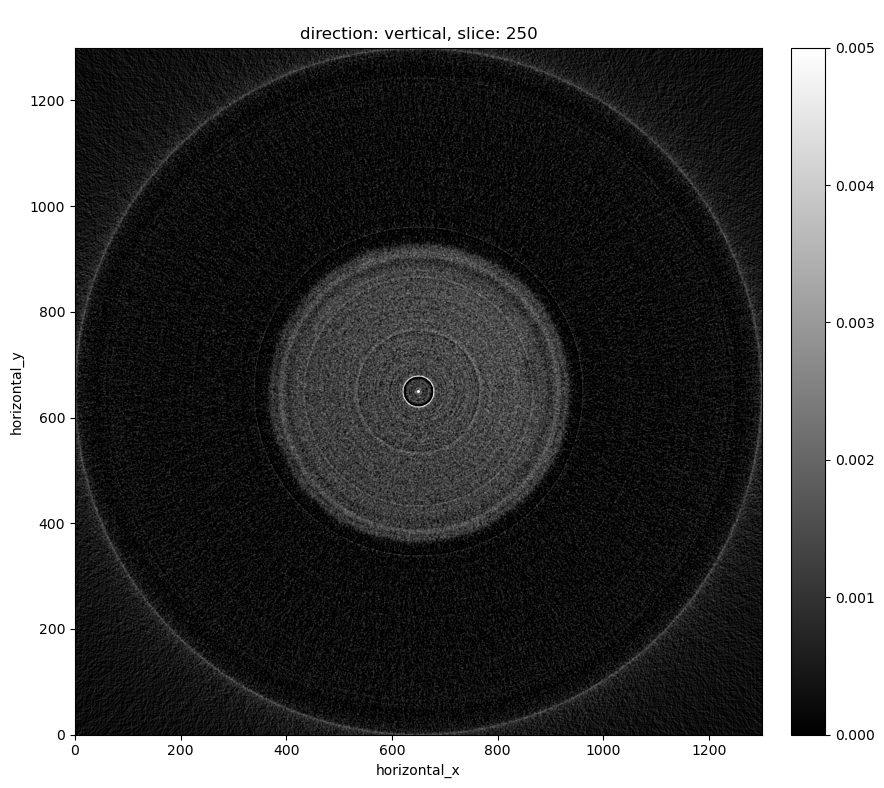

In [25]:
show2D(rec1,slice_list=[250],fix_range=(0,0.005))

In [26]:
from cil.io import TIFFWriter
writer = TIFFWriter()
writer.set_up(data=rec1,
            file_name='N:/ILL_Data_230808/rawdata/AC/Processed/FBP_no_smooth_tiff/FBP_recon.tiff')
# write data
writer.write()

INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FBP_tiff
INFO:cil.io.TIFF:file_name FBP_recon


### FBP with Projection Smoothing

In [43]:
proj_normed = io.volread('N:/ILL_Data_230808/Jupyter_notebooks/median_proj.tiff')
proj_normed = np.array(proj_normed, dtype = np.float32)

In [44]:
ag = AcquisitionGeometry.create_Parallel3D()  \
         .set_panel(num_pixels=[list(proj_normed.shape)[2],list(proj_normed.shape)[1]])        \
         .set_angles(angles=angles)

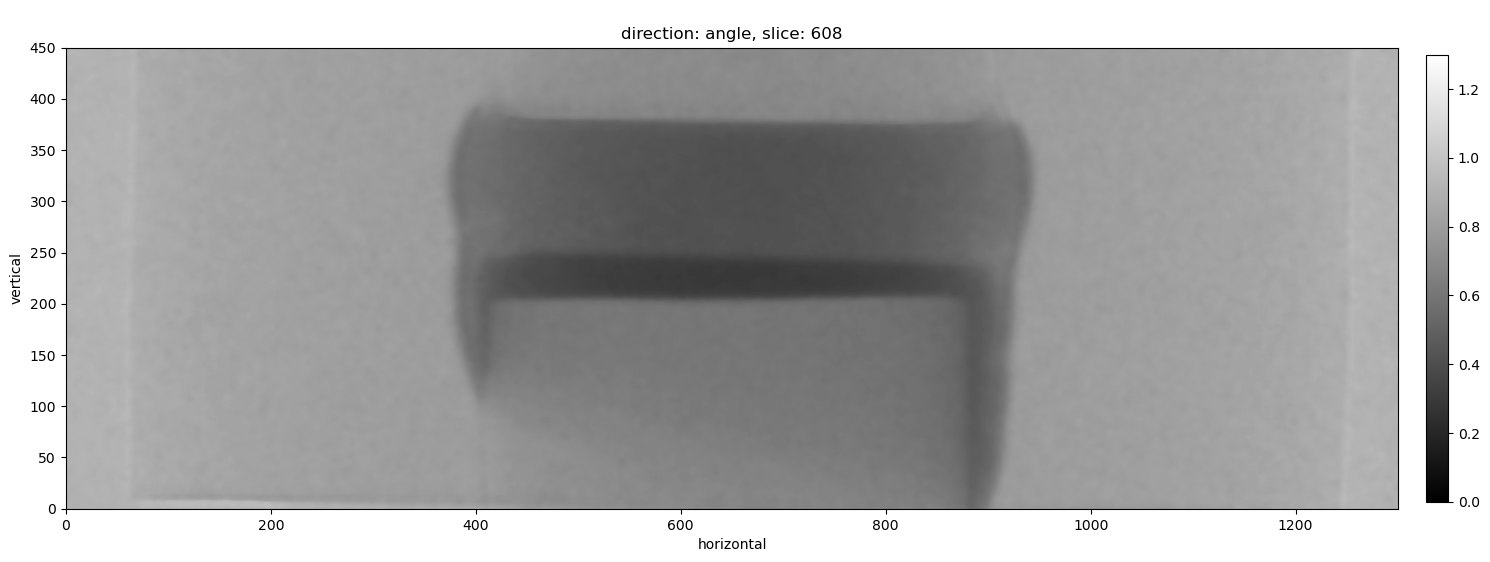

In [45]:
data = AcquisitionData(proj_normed, geometry = ag, deep_copy = True) 
show2D(data,fix_range=(0,1.3))

In [46]:
data.reorder('astra')
ig = ag.get_ImageGeometry()

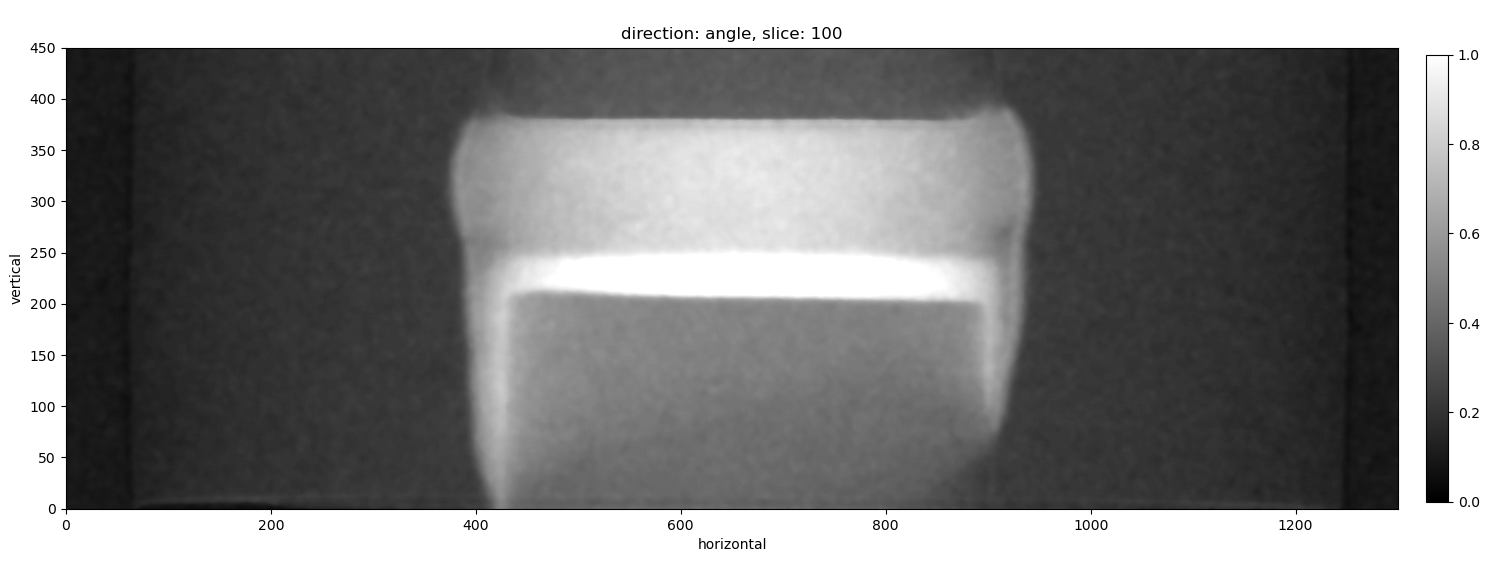

In [47]:
data3 = TransmissionAbsorptionConverter(white_level = 1,  min_intensity = 0.0001)(data)
show2D(data3,fix_range=(0,1), slice_list = ('angle', 100))

In [49]:
data3.reorder('astra')
rec2 = FBP(data3, ig, filter='hamming', backend = 'astra').run()

FBP recon

Input Data:
	vertical: 450
	angle: 1216
	horizontal: 1300

Reconstruction Volume:
	vertical: 450
	horizontal_y: 1300
	horizontal_x: 1300

Reconstruction Options:
	Backend: astra
	Filter: hamming
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



INFO:root:Standard Operator is returned.


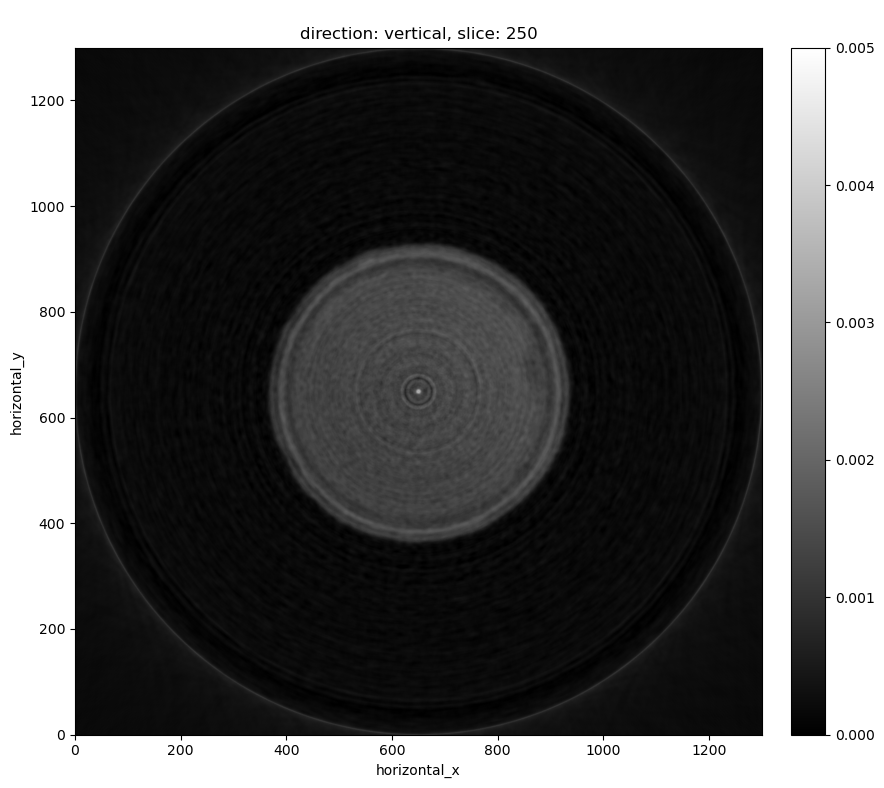

In [50]:
show2D(rec2,slice_list=[250],fix_range=(0,0.005))

In [52]:
from cil.io import TIFFWriter
writer = TIFFWriter()
writer.set_up(data=rec2,
            file_name='N:/ILL_Data_230808/rawdata/AC/Processed/FBP_smooth_tiff/FBP_recon.tiff')
# write data
writer.write()

INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FBP_smooth_tiff
INFO:cil.io.TIFF:file_name FBP_recon


### Ring Removal :)

In [62]:
# Ring removal and de-zinger is best done on the non-smoothed data set first (i think?)
import algotom.prep.removal as tom

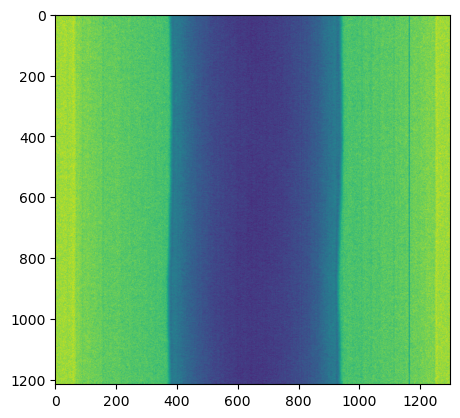

In [58]:
proj_normed = io.volread('N:/ILL_Data_230808/Jupyter_notebooks/adapt_proj.tiff')
plt.imshow((proj_normed[:,350,:]), cmap = 'viridis')
plt.title('OG Sinogram')
plt.show()

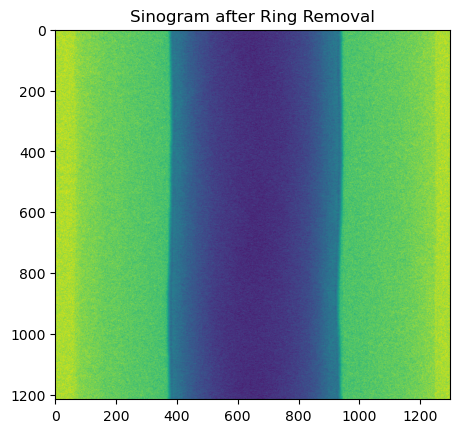

In [68]:
sino = tom.remove_all_stripe(proj_normed[:,350,:])
plt.imshow(sino, cmap = 'viridis')
plt.title('Sinogram after Ring Removal')
plt.show()

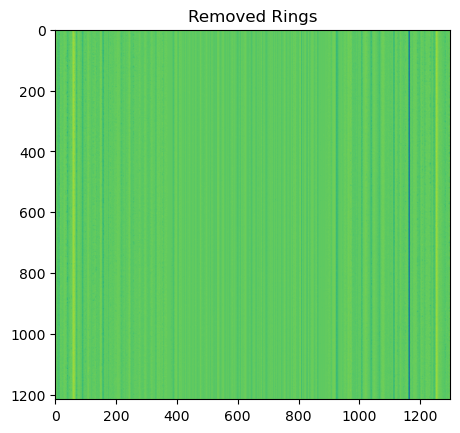

In [69]:
diff = proj_normed[:,350,:] - sino
plt.imshow(diff, cmap = 'viridis')
plt.title('Removed Rings')
plt.show()

In [72]:
#This should probably be accelerated somehow....
ringremd = []
for s in tqdm(range(450)):
    sino = tom.remove_all_stripe(proj_normed[:,s,:])
    ringremd.append(sino)
plt.imshow((ringremd[:,350,:]), cmap = 'viridis')
plt.show()

In [77]:
ringremd = np.array(ringremd)

In [76]:
ringremd.shape

(450, 1216, 1300)

In [78]:
proj = []
for i in range(1216):
    p = ringremd[:,i,:]
    proj.append(p)
io.volwrite('N:/ILL_Data_230808/rawdata/AC/Processed/ring_rem_proj.tiff', proj, format = 'tiff', bigtiff = True)

In [79]:
#also get all the removed rings so that these can be retroactively subtracted from existing processed projections
diff_arr = proj_normed - np.array(proj)
io.volwrite('N:/ILL_Data_230808/rawdata/AC/Processed/rings.tiff', diff_arr, format = 'tiff', bigtiff = True)

### Manual CoR Finding

In [139]:
import algotom.rec.reconstruction as rec
proj_normed = io.volread('N:/ILL_Data_230808/rawdata/AC/Processed/median_rr_proj.tiff')

In [141]:
cor_finder = []
for centre in range(500, 700, 1):
    recon = rec.fbp_reconstruction(proj_normed[:,350,:], centre, angles, ratio=0.95, ramp_win=None, filter_name='hamming', pad=None, pad_mode='edge', apply_log=True, gpu=False, block=(16, 16), ncore=None)
    cor_finder.append(recon)
cor_finder = np.array(cor_finder)
io.volwrite('N:/ILL_Data_230808/rawdata/AC/Processed/cor_finder.tiff', cor_finder, format='tiff')

In [ ]:
# centre 657

### FBP with Projection Smoothing and Ring Removal 

In [81]:
proj_normed = io.volread('N:/ILL_Data_230808/rawdata/AC/Processed/ring_rem_proj.tiff')
proj_filt = median(proj_normed, cube(7))
proj_filt = np.nan_to_num(proj_filt)
proj_filt = proj_filt/np.amax(proj_filt)
io.volwrite('N:/ILL_Data_230808/rawdata/AC/Processed/median_rr_proj.tiff', proj_filt, format='tiff', bigtiff=True)

In [221]:
proj_normed = io.volread('N:/ILL_Data_230808/rawdata/AC/Processed/median_rr_proj.tiff')
proj_normed = np.array(proj_normed, dtype = np.float32)

In [222]:
proj_normed.shape

(1216, 450, 1300)

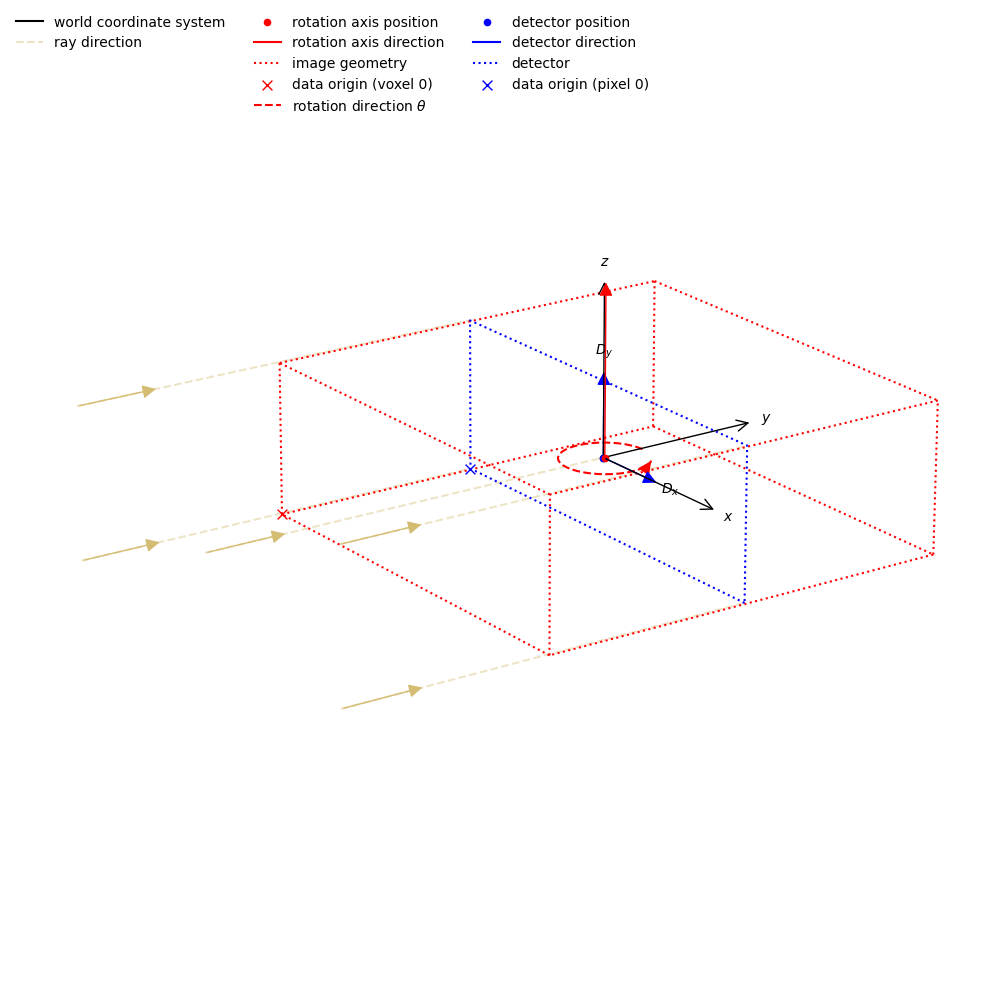

In [248]:
ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_position = [7,0,0])  \
         .set_panel(num_pixels=[list(proj_normed.shape)[2],list(proj_normed.shape)[1]])        \
         .set_angles(angles=angles)
show_geometry(ag)

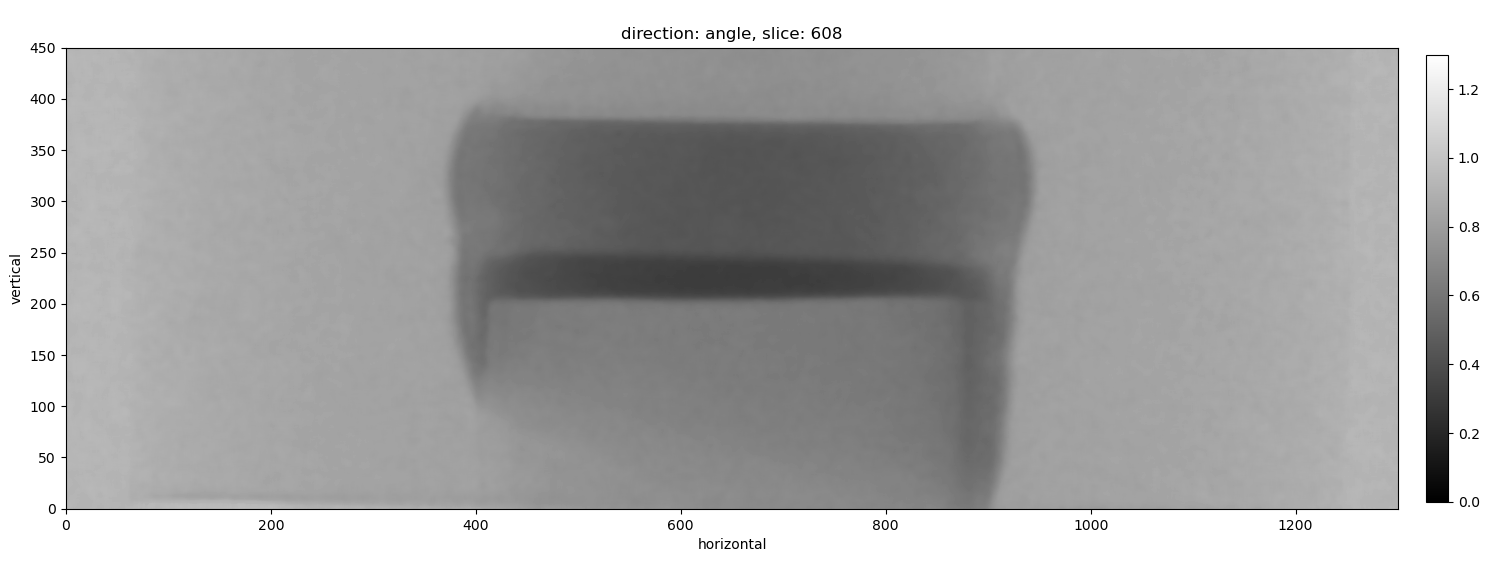

In [249]:
data = AcquisitionData(proj_normed, geometry = ag, deep_copy = True) 
show2D(data,fix_range=(0,1.3))

In [250]:
data.reorder('astra')
ig = ag.get_ImageGeometry()

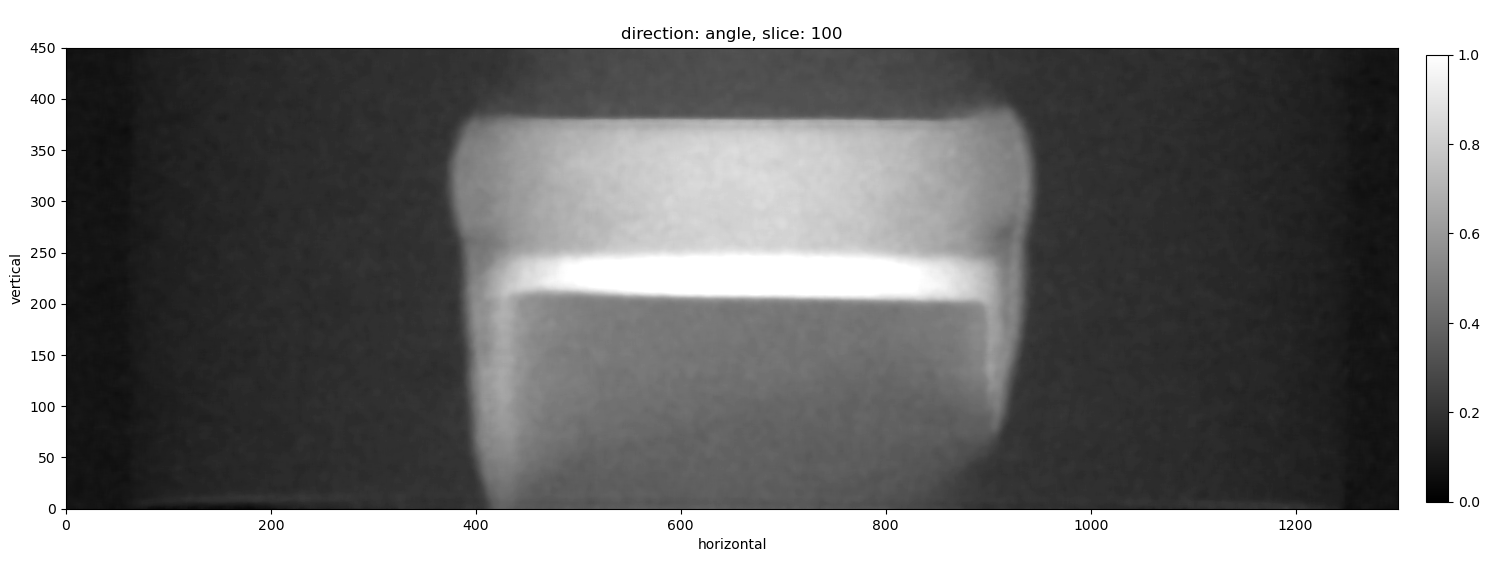

In [251]:
data4 = TransmissionAbsorptionConverter(white_level = 1,  min_intensity = 0.0001)(data)
show2D(data4,fix_range=(0,1), slice_list = ('angle', 100))

In [252]:
from cil.processors import CentreOfRotationCorrector
data4.reorder('astra')
#processor = CentreOfRotationCorrector.image_sharpness()
#processor.set_input(data4)
#processor.get_output(out=data4)
rec3 = FBP(data4, ig, filter='ram-lak', backend = 'astra').run()

FBP recon

Input Data:
	vertical: 450
	angle: 1216
	horizontal: 1300

Reconstruction Volume:
	vertical: 450
	horizontal_y: 1300
	horizontal_x: 1300

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



INFO:root:Standard Operator is returned.


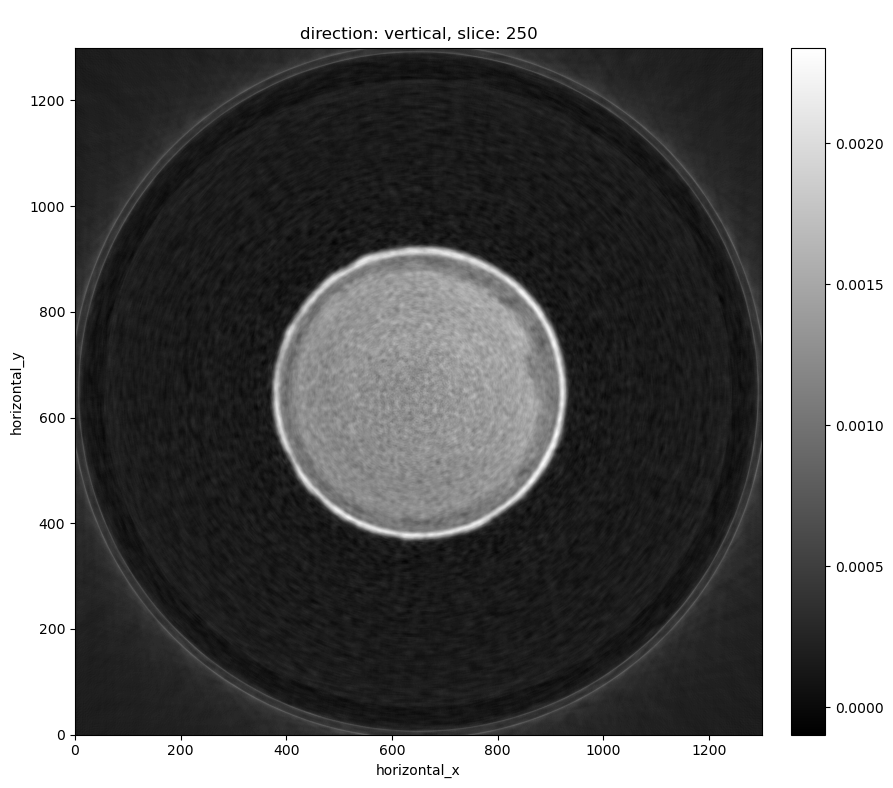

In [253]:
show2D(rec3,slice_list=[250])

In [254]:
from cil.io import TIFFWriter
writer = TIFFWriter()
writer.set_up(data=rec3,
            file_name='N:/ILL_Data_230808/rawdata/AC/Processed/FBP_smooth_rr_tiff/FBP_recon.tiff')
# write data
writer.write()

INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FBP_smooth_rr_tiff
INFO:cil.io.TIFF:file_name FBP_recon


### FBP Ring Removal but no projection smoothing

In [255]:
proj_normed = io.volread('N:/ILL_Data_230808/rawdata/AC/Processed/ring_rem_proj.tiff')
proj_normed = np.array(proj_normed, dtype = np.float32)
ag = AcquisitionGeometry.create_Parallel3D(rotation_axis_position = [7,0,0])  \
         .set_panel(num_pixels=[list(proj_normed.shape)[2],list(proj_normed.shape)[1]])        \
         .set_angles(angles=angles)

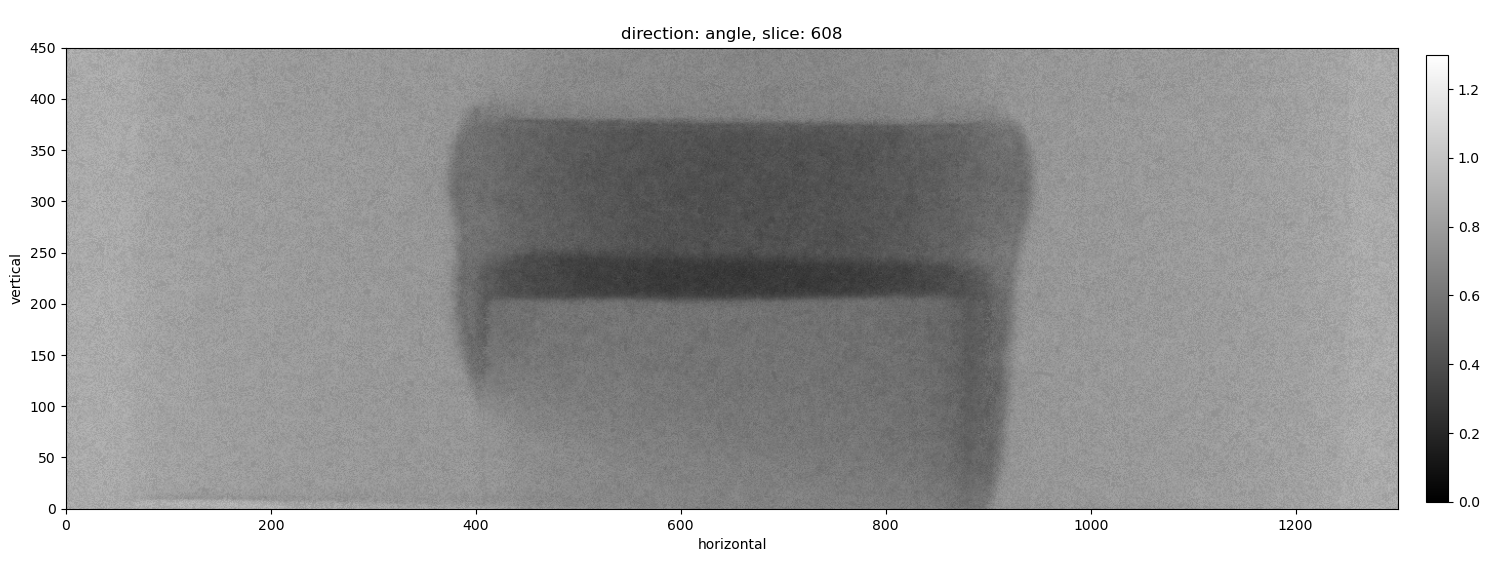

In [256]:
data = AcquisitionData(proj_normed, geometry = ag, deep_copy = True) 
show2D(data,fix_range=(0,1.3))

In [257]:
data.reorder('astra')
ig = ag.get_ImageGeometry()

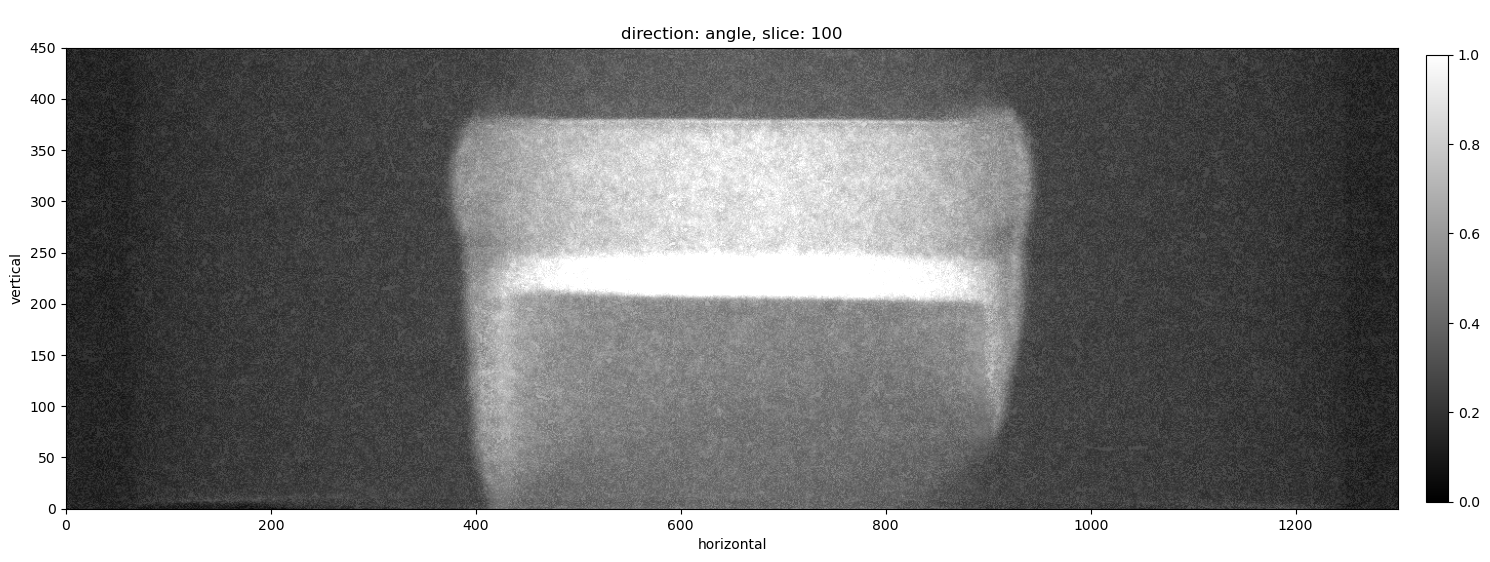

In [258]:
data5 = TransmissionAbsorptionConverter(white_level = 1,  min_intensity = 0.0001)(data)
show2D(data5,fix_range=(0,1), slice_list = ('angle', 100))

In [259]:
data5.reorder('astra')
rec4 = FBP(data5, ig, filter='ram-lak', backend = 'astra').run()

FBP recon

Input Data:
	vertical: 450
	angle: 1216
	horizontal: 1300

Reconstruction Volume:
	vertical: 450
	horizontal_y: 1300
	horizontal_x: 1300

Reconstruction Options:
	Backend: astra
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 12
	Filter_inplace: False
	Split processing: 0

Reconstructing in 1 chunk(s):



INFO:root:Standard Operator is returned.


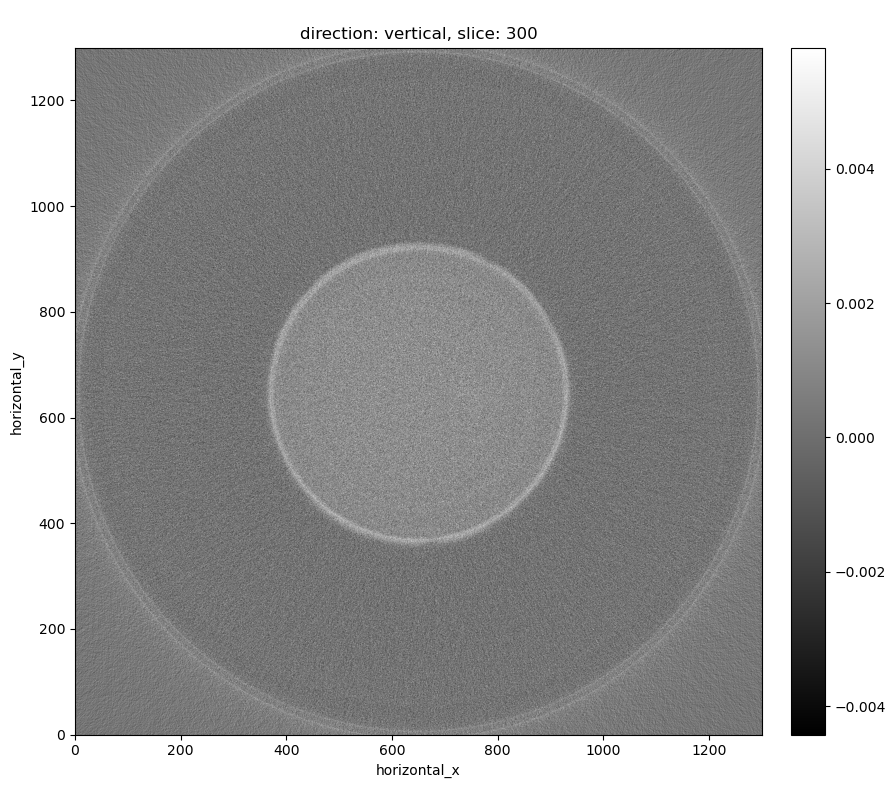

In [260]:
show2D(rec4,slice_list=[300])

In [261]:
from cil.io import TIFFWriter
writer = TIFFWriter()
writer.set_up(data=rec4,
            file_name='N:/ILL_Data_230808/rawdata/AC/Processed/FBP_no_smooth_rr_tiff/FBP_recon.tiff')
# write data
writer.write()

INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FBP_no_smooth_rr_tiff
INFO:cil.io.TIFF:file_name FBP_recon


### FISTA with Projection Smoothing and Ring Removal

In [285]:
import os
A = ProjectionOperator(ig, ag, device = 'gpu')
b = data4

INFO:root:Standard Operator is returned.


In [286]:
F = LeastSquares(A, b)
G = IndicatorBox(lower=0.0)

INFO:root:Numba backend is used.
INFO:root:Assuming that x is a numpy array or a number


In [287]:
x0 = ig.allocate(0.0)
myFISTANN = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  max_iteration=1000,
                  update_objective_interval = 10)

INFO:root:FISTA setting up
INFO:root:FISTA configured


In [288]:
tlist = [10,20,30,40,50,60,70,80,90,100,125,150,200]
ilist = [10,10,10,10,10,10,10,10,10,10,25,25,50]
for i,t in zip(ilist,tlist):
    myFISTANN.run(i, verbose=1)
    os.makedirs(f'N:/ILL_Data_230808/rawdata/AC/Processed/FISTA_recs/FISTA_i{t}_tiff')
    writer = TIFFWriter()
    writer.set_up(data=myFISTANN.solution,file_name=f'N:/ILL_Data_230808/rawdata/AC/Processed/FISTA_recs/FISTA_i{t}_tiff/FISTA_recon.tiff')
    writer.write()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.12470e+08


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i10_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       10       1000        31.229          3.60932e+05
-------------------------------------------------------
       10       1000        31.229          3.60932e+05
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       1000        31.229          3.60932e+05


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i20_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       20       1000        31.140          1.25617e+05
-------------------------------------------------------
       20       1000        31.140          1.25617e+05
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       20       1000        31.140          1.25617e+05


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i30_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       30       1000        31.197          9.96068e+04
-------------------------------------------------------
       30       1000        31.197          9.96068e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       30       1000        31.197          9.96068e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i40_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       40       1000        31.086          9.34413e+04
-------------------------------------------------------
       40       1000        31.086          9.34413e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       40       1000        31.086          9.34413e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i50_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       50       1000        30.982          9.14042e+04
-------------------------------------------------------
       50       1000        30.982          9.14042e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       50       1000        30.982          9.14042e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i60_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       60       1000        31.001          9.05053e+04
-------------------------------------------------------
       60       1000        31.001          9.05053e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       60       1000        31.001          9.05053e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i70_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       70       1000        30.930          8.99598e+04
-------------------------------------------------------
       70       1000        30.930          8.99598e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       70       1000        30.930          8.99598e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i80_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       80       1000        30.955          8.96155e+04
-------------------------------------------------------
       80       1000        30.955          8.96155e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       80       1000        30.955          8.96155e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i90_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       90       1000        30.937          8.93890e+04
-------------------------------------------------------
       90       1000        30.937          8.93890e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       90       1000        30.937          8.93890e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i100_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      100       1000        30.938          8.92218e+04
-------------------------------------------------------
      100       1000        30.938          8.92218e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      100       1000        30.938          8.92218e+04
      110       1000        30.939          8.90960e+04
      120       1000        30.913          8.90042e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i125_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


-------------------------------------------------------
      125       1000        30.914                     
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      125       1000        30.914                     
      130       1000        30.917          8.89354e+04
      140       1000        30.897          8.88820e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i150_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      150       1000        30.852          8.88401e+04
-------------------------------------------------------
      150       1000        30.852          8.88401e+04
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      150       1000        30.852          8.88401e+04
      160       1000        30.819          8.88060e+04
      170       1000        30.811          8.87773e+04
      180       1000        30.808          8.87528e+04
      190       1000        30.777          8.87323e+04


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i200_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      200       1000        30.747          8.87147e+04
-------------------------------------------------------
      200       1000        30.747          8.87147e+04
Stop criterion has been reached.



### FISTA with Ring Removal but NO Projection Smoothing

In [289]:
A = ProjectionOperator(ig, ag, device = 'gpu')
b = data5
F = LeastSquares(A, b)
G = IndicatorBox(lower=0.0)
x0 = ig.allocate(0.0)
myFISTANN_NS = FISTA(f=F, 
                  g=G, 
                  initial=x0, 
                  max_iteration=1000,
                  update_objective_interval = 10)

INFO:root:Standard Operator is returned.
INFO:root:Numba backend is used.
INFO:root:Assuming that x is a numpy array or a number
INFO:root:FISTA setting up
INFO:root:FISTA configured


In [290]:
tlist = [10,20,30,40,50,60,70,80,90,100,125,150,200]
ilist = [10,10,10,10,10,10,10,10,10,10,25,25,50]
for i,t in zip(ilist,tlist):
    myFISTANN_NS.run(i, verbose=1)
    os.makedirs(f'N:/ILL_Data_230808/rawdata/AC/Processed/FISTA_recs/FISTA_i{t}_no_smooth_tiff')
    writer = TIFFWriter()
    writer.set_up(data=myFISTANN.solution,file_name=f'N:/ILL_Data_230808/rawdata/AC/Processed/FISTA_recs/FISTA_i{t}_no_smooth_tiff/FISTA_recon.tiff')
    writer.write()

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.48031e+08


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i10_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       10       1000        35.071          2.11315e+06
-------------------------------------------------------
       10       1000        35.071          2.11315e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       1000        35.071          2.11315e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i20_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       20       1000        34.033          1.77727e+06
-------------------------------------------------------
       20       1000        34.033          1.77727e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       20       1000        34.033          1.77727e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i30_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       30       1000        33.391          1.65811e+06
-------------------------------------------------------
       30       1000        33.391          1.65811e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       30       1000        33.391          1.65811e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i40_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       40       1000        33.100          1.57222e+06
-------------------------------------------------------
       40       1000        33.100          1.57222e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       40       1000        33.100          1.57222e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i50_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       50       1000        32.914          1.50777e+06
-------------------------------------------------------
       50       1000        32.914          1.50777e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       50       1000        32.914          1.50777e+06
       60       1000        32.800          1.45851e+06
-------------------------------------------------------
       60       1000        32.800          1.45851e+06
Stop criterion has been reached.



INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i60_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       60       1000        32.800          1.45851e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i70_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       70       1000        32.729          1.42019e+06
-------------------------------------------------------
       70       1000        32.729          1.42019e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       70       1000        32.729          1.42019e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i80_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       80       1000        32.774          1.39017e+06
-------------------------------------------------------
       80       1000        32.774          1.39017e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       80       1000        32.774          1.39017e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i90_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


       90       1000        32.699          1.36660e+06
-------------------------------------------------------
       90       1000        32.699          1.36660e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       90       1000        32.699          1.36660e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i100_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      100       1000        32.668          1.34805e+06
-------------------------------------------------------
      100       1000        32.668          1.34805e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      100       1000        32.668          1.34805e+06
      110       1000        32.586          1.33344e+06
      120       1000        32.511          1.32191e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i125_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


-------------------------------------------------------
      125       1000        32.497                     
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      125       1000        32.497                     
      130       1000        32.483          1.31282e+06
      140       1000        32.467          1.30566e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i150_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      150       1000        32.438          1.30002e+06
-------------------------------------------------------
      150       1000        32.438          1.30002e+06
Stop criterion has been reached.

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
      150       1000        32.438          1.30002e+06
      160       1000        32.438          1.29557e+06
      170       1000        32.412          1.29206e+06
      180       1000        32.400          1.28929e+06
      190       1000        32.382          1.28710e+06


INFO:cil.io.TIFF:dir_name N:\ILL_Data_230808\rawdata\AC\Processed\FISTA_recs\FISTA_i200_no_smooth_tiff
INFO:cil.io.TIFF:file_name FISTA_recon


      200       1000        32.359          1.28535e+06
-------------------------------------------------------
      200       1000        32.359          1.28535e+06
Stop criterion has been reached.

